In [1]:
import scipy.io as scio  
from skimage import io
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import math
import glob

In [2]:
def cell_cut(folders_outline,folders_annatated,folders_raw):
    '''
    根据细胞的轮廓提取出重心，而且根据轮廓的的大小选好一个来提取出细胞。根据提取出的细胞里面的标注进行分类保存;
    '''
    #folders_outline是细胞轮廓的路径;
    #folders_annatated是标注好的细胞的路径
    #folders_raw是原始细胞的路径
    img_list_outline= os.listdir('./'+folders_outline)
    img_list_annatated= os.listdir('./'+folders_annatated)
    img_list_raw= os.listdir('./'+folders_raw)
    #遍历里面的文件，得出文件名
    for m in range(len(img_list_annatated)):
        data = scio.loadmat('./'+folders_outline+'/'+img_list_outline[m])
        data = data['single_mask']
        #提取出.mat的文件，并提取出single_mask里的数据，里面是每一个细胞轮廓的数据
        img = cv2.imread('./'+folders_annatated + '/' + os.path.splitext(img_list_outline[m])[0]+'.png')
        img_raw = cv2.imread('./'+folders_raw + '/' + os.path.splitext(img_list_outline[m])[0]+'.png')
        #读取出原始细胞和标注好的细胞
        k=1
        #因为下面会有些细胞不符合要求，就背舍弃，用k来命名我们选择保存的细胞的编号
        for n in range(data.shape[2]):
            ret,thresh = cv2.threshold(data[:,:,n],0,255,0)
            #二值化处理
            image, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
            #找到轮廓的坐标
            x,y,w,h = cv2.boundingRect(contours[0])
            #根据轮廓找出轮廓左上角的坐标和对应的边长
            slide = max(w,h)
            #选出最长的那个作为我们外界矩形的边长
            #x1 = x+slide
            #y1 = y+slide
            M = cv2.moments(contours[0])
            try:
                cx = int(M['m10']/M['m00'])
                cy = int(M['m01']/M['m00'])
            except ZeroDivisionError:
                continue
            #算出重心，因为可能出现除以0的操作，所以要进行文件异常操作处理
            else:
                x1 = cx-math.ceil(slide/2)
                y1 = cy-math.ceil(slide/2)
                x2 = cx+math.ceil(slide/2)
                y2 = cy+math.ceil(slide/2)
                if (cx<math.ceil(slide/2))or(cy<math.ceil(slide/2))or(cx>(513-math.ceil(slide/2)))or(cy>(513-math.ceil(slide/2))):
                    continue
                cropImg = img[y1:y2, x1:x2]
                #截出我们需要的图片
                HSV = cv2.cvtColor(cropImg, cv2.COLOR_BGR2HSV)
                green = yellow = red = 0
                row_num, col_num= HSV.shape[:2]
                card_img_count = row_num * col_num
                for i in range(row_num):
                    for j in range(col_num):
                        H = HSV.item(i, j, 0)
                        S = HSV.item(i, j, 1)
                        V = HSV.item(i, j, 2)
                        if 11 < H <= 34 and S > 34:#图片分辨率调整
                            yellow += 1
                        elif 35 < H <= 99 and S > 34:#图片分辨率调整
                            green += 1
                        elif 177 < H <= 180 and S > 34:#图片分辨率调整
                            red += 1
                if (yellow<10)and(green<10)and(red<10):
                    continue
                if (yellow >= green)and(yellow >= red):
                    dir_name='./breast/plasma cell'
                elif (green >= yellow)and(green >= red):
                    dir_name='./breast/cancer cell'
                elif (red >= yellow)and(red >= green):
                    dir_name='./breast/lymphocyte'
                #以上是对图片内颜色的判断，选出对应的分类。如果没有标注就舍弃
                cropImg = img_raw[y1:y2, x1:x2]
                #对原图进行截取，保存
                if not os.path.exists(dir_name):os.makedirs(dir_name)
                cv2.imwrite(dir_name+'/'+os.path.splitext(img_list_annatated[m])[0]+'_'+str(k)+'.png',cropImg)
                k = k+1
        #dir_name = './breast/index'
        #if not os.path.exists(dir_name):os.makedirs(dir_name)
        #cv2.imwrite(dir_name+'/'+str(img_list_outline[m])+'_.png',img)

In [3]:
if __name__ == '__main__':
    cell_cut("single_mask1/","Cut Patches/breast/annotated/","Cut Patches/breast/Raw/")

In [4]:
def index_show(folders_outline,folders_annatated):
    '''对所选取的图片进行标注索引，便于查看，基本注释和上面一样，只是颜色判断那里添加率对应的画框，标注'''
    img_list_outline= os.listdir('./'+folders_outline)
    img_list_annatated= os.listdir('./'+folders_annatated)
    for m in range(len(img_list_annatated)):
        data = scio.loadmat('./'+folders_outline+'/'+img_list_outline[m])
        data = data['single_mask']
        img = cv2.imread('./'+folders_annatated + '/' + os.path.splitext(img_list_outline[m])[0]+'.png')
        k=1
        for n in range(data.shape[2]):
            ret,thresh = cv2.threshold(data[:,:,n],0,255,0)
            image, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
            x,y,w,h = cv2.boundingRect(contours[0])
            slide = max(w,h)
            #x1 = x+slide
            #y1 = y+slide
            M = cv2.moments(contours[0])
            try:
                cx = int(M['m10']/M['m00'])
                cy = int(M['m01']/M['m00'])
            except ZeroDivisionError:
                continue
            else:
                x1 = cx-math.ceil(slide/2)
                y1 = cy-math.ceil(slide/2)
                x2 = cx+math.ceil(slide/2)
                y2 = cy+math.ceil(slide/2)
                if (cx<math.ceil(slide/2))or(cy<math.ceil(slide/2))or(cx>(513-math.ceil(slide/2)))or(cy>(513-math.ceil(slide/2))):
                    continue
                cropImg = img[y1:y2, x1:x2]
                HSV = cv2.cvtColor(cropImg, cv2.COLOR_BGR2HSV)
                green = yellow = red = 0
                row_num, col_num= HSV.shape[:2]
                card_img_count = row_num * col_num
                for i in range(row_num):
                    for j in range(col_num):
                        H = HSV.item(i, j, 0)
                        S = HSV.item(i, j, 1)
                        V = HSV.item(i, j, 2)
                        if 11 < H <= 34 and S > 34:#图片分辨率调整
                            yellow += 1
                        elif 35 < H <= 99 and S > 34:#图片分辨率调整
                            green += 1
                        elif 177 < H <= 180 and S > 34:#图片分辨率调整
                            red += 1
                if (yellow<10)and(green<10)and(red<10):
                    continue
                if (yellow >= green)and(yellow >= red):
                    #cv2.rectangle(img,(x1,y1),(x2,y2),(0,255,255),1)
                    cv2.drawContours(img,contours,0,(0,255,255),1)
                    font=cv2.FONT_HERSHEY_SIMPLEX
                    cv2.putText(img,str(k),(cx,cy), font, 0.4,(0,255,255),1)
                elif (green >= yellow)and(green >= red):
                    #cv2.rectangle(img,(x1,y1),(x2,y2),(0,255,0),1)
                    cv2.drawContours(img,contours,0,(0,255,0),1)
                    font=cv2.FONT_HERSHEY_SIMPLEX
                    cv2.putText(img,str(k),(cx,cy), font, 0.4,(0,255,0),1)
                elif (red >= yellow)and(red >= green):
                    #cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0),1)
                    cv2.drawContours(img,contours,0,(0,0,255),1)
                    font=cv2.FONT_HERSHEY_SIMPLEX
                    cv2.putText(img,str(k),(cx,cy), font, 0.4,(0,0,255),1)
                
                k = k+1
        dir_name='./breast/index'
        if not os.path.exists(dir_name):os.makedirs(dir_name)
            #cv2.rectangle(img,(x1,y1),(x2,y2),(0,255,0),1)
            #font=cv2.FONT_HERSHEY_SIMPLEX
            #cv2.putText(img,str(k),(cx,cy), font, 0.4,(255,255,255),1) 
        cv2.imwrite(dir_name+'/'+os.path.splitext(img_list_annatated[m])[0]+'.png',img)

In [5]:
if __name__ == '__main__':
    index_show("single_mask1","Cut Patches/breast/annotated")

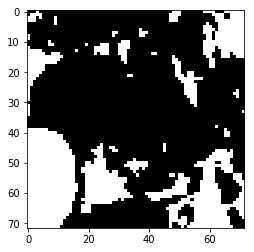

In [13]:
k =1
for i in range(118):
    ret,thresh = cv2.threshold(a[:,:,i],0,255,0)
    image, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    x,y,w,h = cv2.boundingRect(contours[0])
    slide = max(w,h)
    #x1 = x+slide
    #y1 = y+slide
    M = cv2.m0oments(contours[0])
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    x1 = cx-math.ceil(slide/2)
    y1 = cy-math.ceil(slide/2)
    x2 = cx+math.ceil(slide/2)
    y2 = cy+math.ceil(slide/2)
    if (cx<math.ceil(slide/2))or(cy<math.ceil(slide/2))or(cx>(513-math.ceil(slide/2)))or(cy>(513-math.ceil(slide/2))):
        continue
    cropImg = img[y1:y2, x1:x2]
    HSV = cv2.cvtColor(cropImg, cv2.COLOR_BGR2HSV)
    green = yellow = red = 0
    row_num, col_num= HSV.shape[:2]
    card_img_count = row_num * col_num
    for i in range(row_num):
        for j in range(col_num):
            H = HSV.item(i, j, 0)
            S = HSV.item(i, j, 1)
            V = HSV.item(i, j, 2)
            if 11 < H <= 34 and S > 34:#图片分辨率调整
                yellow += 1
            elif 35 < H <= 99 and S > 34:#图片分辨率调整
                green += 1
            elif 177 < H <= 180 and S > 34:#图片分辨率调整
                red += 1
    if (yellow<10)and(green<10)and(red<10):
        continue
    if (yellow >= green)and(yellow >= red):
        dir_name='./breast/plasma cell'
    elif (green >= yellow)and(green >= red):
        dir_name='./breast/cancer cell'
    elif (red >= yellow)and(red >= green):
        dir_name='./breast/lymphocyte'
    if not os.path.exists(dir_name):os.makedirs(dir_name)
    cv2.imwrite(dir_name+'/'+str(k)+'_.png',cropImg)
    #cv2.rectangle(img,(x,y),(x1,y1),(0,255,0),1)
    #font=cv2.FONT_HERSHEY_SIMPLEX
    #cv2.putText(img,str(k),(cx,cy), font, 0.4,(255,255,255),1)
    k = k+1
dir_name = './breast/index'
if not os.path.exists(dir_name):os.makedirs(dir_name)
cv2.imwrite(dir_name+'/'+'sum'+'_.png',img)

0
red


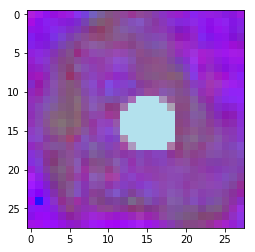

In [4]:
ret,thresh = cv2.threshold(a[:,:,80],0,255,0)
image, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
x,y,w,h = cv2.boundingRect(contours[0])
slide = max(w,h)
x1 = x+slide
y1 = y+slide
M = cv2.moments(contours[0])
cx = int(M['m10']/M['m00'])
cy = int(M['m01']/M['m00'])
x1 = cx-math.ceil(slide/2)
y1 = cy-math.ceil(slide/2)
x2 = cx+math.ceil(slide/2)
y2 = cy+math.ceil(slide/2)
#if (cx<math.ceil(slide/2))or(cy<math.ceil(slide/2))or(cx>(513-math.ceil(slide/2)))or(cy>(513-math.ceil(slide/2))):
    #continue
cropImg = img[y1:y2, x1:x2]
green = yello = red = black = white = 0
HSV = cv2.cvtColor(cropImg, cv2.COLOR_BGR2HSV)
plt.imshow(HSV,'gray')
row_num, col_num= HSV.shape[:2]
card_img_count = row_num * col_num
for i in range(row_num):
    for j in range(col_num):
        H = HSV.item(i, j, 0)
        S = HSV.item(i, j, 1)
        V = HSV.item(i, j, 2)
        if 11 < H <= 34 and S > 34:#图片分辨率调整
            yello += 1
        elif 35 < H <= 99 and S > 34:#图片分辨率调整
            green += 1
        elif 156 < H <= 180 and S > 34:#图片分辨率调整
            red += 1
color = "no"
limit1 = limit2 = 0
print(yello)
''''''
if (yello >= green)and(yello >= red):
    color = "yello"
    limit1 = 11
    limit2 = 34#有的图片有色偏偏绿
elif (green >= yello)and(green >= red):
    color = "green"
    limit1 = 35
    limit2 = 99
elif (red >= yello)and(red >= green):
    color = "red"
    limit1 = 0
    limit2 = 10#有的图片有色偏偏紫
print(color)